# Heisen (2023) - Efficient Parallelization of a Ubiquitous Sequential Computation

In [1]:
!which python

/Users/tristantorchet/Desktop/Code/VSCode/LearningJAX/.venv/bin/python


In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

jnp.set_printoptions(precision=2)

## 1. simple cumsum

In [10]:
seq_len = 1000
key = jax.random.PRNGKey(0)
key, subkey_a = jax.random.split(key)
a = jax.random.normal(subkey_a, (seq_len,))

### 1.1 Using a for loop to compute the correct cumsum which will be used to verify the correctness of the parallelized version

In [11]:
gt_result = []
x_t = 0 
for i in range(seq_len):
    x_t += a[i]
    gt_result.append(x_t)
gt_result = jnp.array(gt_result)
print(gt_result.shape)
print(gt_result[:5])

(1000,)
[ 1.2365611   0.08250463 -1.9398266  -2.4568925  -2.713965  ]


### 1.2 Comparing the speed of manual, jit_manual, lax.scan, and jnp.cumsum

In [16]:
def cumsum_manual(a):
    x_t = 0
    x_cs = []
    for i in range(seq_len):
        x_t += a[i]
        x_cs.append(x_t)
    return jnp.array(x_cs)

jit_cumsum_manual = jax.jit(cumsum_manual)

def cumsum_lax_scan(state, a):
    x_t = state
    x_t += a
    return x_t, x_t # state and output

x_0 = 0.
_, result_lax_scan = jax.lax.scan(cumsum_lax_scan, x_0, a)
result_jit = jit_cumsum_manual(a) # warm up
result_jnpcs = jnp.cumsum(a) # warm up
result_lax_ass_scan = jax.lax.associative_scan(jnp.add, a) # warm up

print('Lax scan correct:')
print(jnp.allclose(result_lax_scan, gt_result, atol=1e-6))
print('Jit correct:')
print(jnp.allclose(result_jit, gt_result, atol=1e-6))
print('Jnp cumsum correct:')
print(jnp.allclose(result_jnpcs, gt_result, atol=1e-4)) # need a higher atol
print('lax associative scan correct:')
print(jnp.allclose(result_lax_ass_scan, gt_result, atol=1e-4)) # need a higher atol



print('\nmanual')
%timeit -n 1 -r 7 cumsum_manual(a)
print('\njit manual')
%timeit -n 1 -r 7 jit_cumsum_manual(a)
print('\nlax scan')
%timeit -n 1 -r 7 jax.lax.scan(cumsum_lax_scan, x_0, a)
print('\ncumsum jnp')
%timeit -n 1 -r 7 jnp.cumsum(a)
print('\nlax ass scan')
%timeit -n 1 -r 7 jax.lax.associative_scan(jnp.add, a)

Lax scan correct:
True
Jit correct:
True
Jnp cumsum correct:
True
lax associative scan correct:
True

manual
70.5 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

jit manual
The slowest run took 19.55 times longer than the fastest. This could mean that an intermediate result is being cached.
33.1 μs ± 52.1 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)

lax scan
91.9 μs ± 43.2 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)

cumsum jnp
8.93 μs ± 3.45 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)

lax ass scan
1.06 ms ± 205 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 2. Affine cumsum

In [17]:
seq_len = 1000
key = jax.random.PRNGKey(0)
key, subkey_a, subkey_b = jax.random.split(key, 3)
a = jax.random.normal(subkey_a, (seq_len,))
b = jax.random.normal(subkey_b, (seq_len,))
print(a[:5])

[-9.9657071e-01 -9.7286172e-04 -4.8290953e-01 -1.5715115e+00
 -6.2422973e-01]


### 2.1 Using a for loop to compute the correct affine cumsum which will be used to verify the correctness of the parallelized version

In [18]:
gt_aff_cs_res = []
x_t = 0
gt_aff_cs_res.append(x_t)
for i in range(seq_len):
    x_t = a[i] * x_t + b[i]
    gt_aff_cs_res.append(x_t)
gt_aff_cs_res = jnp.array(gt_aff_cs_res)

In [19]:
def affine_cumsum_manual(a, b):
    x_cs = []
    x_t = 0
    x_cs.append(x_t)
    for i in range(seq_len):
        x_t = a[i] * x_t + b[i]
        x_cs.append(x_t)
    return jnp.array(x_cs)

result_aff_cs_man = affine_cumsum_manual(a, b)
print(jnp.allclose(gt_aff_cs_res, result_aff_cs_man, atol=1e-6))

%timeit -n 1 -r 7 affine_cumsum_manual(a, b)

True
107 ms ± 8.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
_ = jit_affine_cumsum_manual(a, b) # this takes a while ~ 16s

# warm up
_ = jit_affine_cumsum_manual(a, b) # this takes a while ~ 16s
%timeit -n 1 -r 7 jit_affine_cumsum_manual(a, b)

NameError: name 'jit_affine_cumsum_manual' is not defined

## 3 Recursion using cumsum
We need to ensure that $a$ and $b$ are <font color='red'>positive</font> because the acceleration uses logaritmic scale.

In [3]:
seq_len = 1000
key = jax.random.PRNGKey(0)
key, subkey_a, subkey_b = jax.random.split(key, 3)
a = jax.random.normal(subkey_a, (seq_len,))
a = jnp.abs(a) # make sure it is positive, because we will use log
b = jax.random.normal(subkey_b, (seq_len,))
b = jnp.abs(b) # make sure it is positive, because we will use log
print(a[:5])

[9.97e-01 9.73e-04 4.83e-01 1.57e+00 6.24e-01]


In [4]:
gt_aff_cs_res = []
x_t = 1
gt_aff_cs_res.append(x_t)
for i in range(seq_len):
    x_t = a[i] * x_t + b[i]
    gt_aff_cs_res.append(x_t)
gt_aff_cs_res = jnp.array(gt_aff_cs_res)

### 3.1 Using Heinsen vanilla formulation (unstable if the cumulative prodct goes to zero)

In [32]:
@jax.jit
def cumprod(a):
    x_t = 1.
    res = []
    for _, a in enumerate(a):
        x_t *= a 
        res.append(x_t)
    return jnp.array(res)

a_cp = cumprod(a)
print(a_cp[:5])
print(a[:5])

@jax.jit
def cumsum_div(x, y):
    return jnp.cumsum(x/y)

c = cumsum_div(b, a_cp)
print(c[:5])

[9.9657071e-01 9.6952548e-04 4.6819309e-04 7.3577085e-04 4.5929005e-04]
[9.9657071e-01 9.7286172e-04 4.8290953e-01 1.5715115e+00 6.2422973e-01]
[1.7909826e-01 1.9601681e+03 2.2337986e+03 5.0242344e+03 7.8337881e+03]


As the cumulative product of $a$ is used in the denominator, the recursion is unstable if the cumulative product goes to zero.

In [33]:
# check if a_cp has a 0
print(jnp.any(a_cp == 0))

True


Indeed, running the following cells, we will see that the $final$ sequences has `nan` values.

In [34]:
# d = inputs[0] + c 
d = 1 + c 
final = a_cp * d
print(final[:5])
print(gt_aff_cs_res[1:6])

[1.1750548 1.9014025 1.0463172 3.697421  3.5984402]
[1.1750548 1.9014025 1.0463173 3.697421  3.5984402]


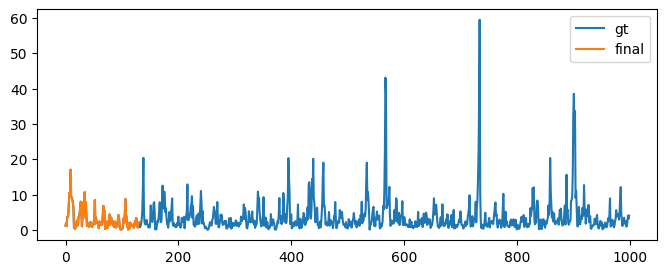

In [35]:
# plot 
import matplotlib.pyplot as plt
px = 1/plt.rcParams['figure.dpi']  # pixel in inches
gt_to_plot = gt_aff_cs_res[1:]
final_to_plot = final
fig, ax = plt.subplots(1,1, figsize=(800*px, 300*px))
t = np.arange(seq_len)
ax.plot(t, gt_to_plot, label='gt')
ax.plot(t, final_to_plot, label='final')
ax.legend()
plt.show()


### 3.2 Using Heinsen stable formulation using log

### 3.2.1 Stable jax.lax.cumlogsumexp

In [43]:
log_a = jnp.log(a)
a_star = jnp.cumsum(log_a)

log_b = jnp.log(b)
c = log_b - a_star 
c_star = jnp.zeros((c.shape[0]+ 1, ))
c_star = c_star.at[1:].set(c)
c_star = c_star.at[0].set(0)
d = jax.lax.cumlogsumexp(c_star)
d = d[1:] # tailing d
log_final = a_star + d



print(jnp.allclose(log_final, jnp.log(gt_aff_cs_res[1:]), atol=1e-4))

True


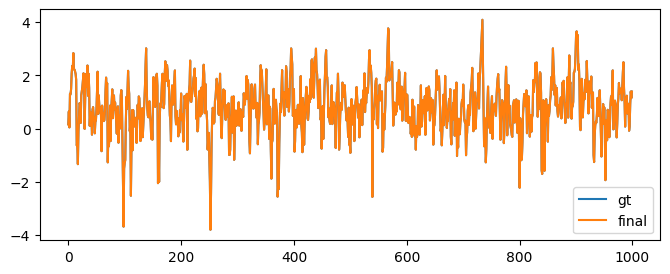

In [41]:
# plot 
import matplotlib.pyplot as plt
px = 1/plt.rcParams['figure.dpi']  # pixel in inches
gt_to_plot = jnp.log(gt_aff_cs_res[1:])
final_to_plot = log_final
fig, ax = plt.subplots(1,1, figsize=(800*px, 300*px))
t = np.arange(seq_len)
ax.plot(t, gt_to_plot, label='gt')
ax.plot(t, final_to_plot, label='final')
ax.legend()
plt.show()


### 3.2.2 Understanding the stability issue

In [5]:
log_a = jnp.log(a)
log_b = jnp.log(b)
a_star = jnp.cumsum(log_a)
c = jnp.exp(log_b - a_star)
d = 1 + jnp.cumsum(c)
log_final = a_star + jnp.log(d)
print(jnp.allclose(log_final, jnp.log(gt_aff_cs_res[1:]), atol=1e-6))

False


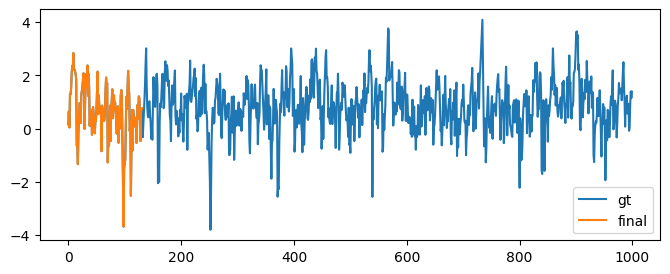

In [6]:
# plot 
import matplotlib.pyplot as plt
px = 1/plt.rcParams['figure.dpi']  # pixel in inches
gt_to_plot = jnp.log(gt_aff_cs_res[1:])
final_to_plot = log_final
fig, ax = plt.subplots(1,1, figsize=(800*px, 300*px))
t = np.arange(seq_len)
ax.plot(t, gt_to_plot, label='gt')
ax.plot(t, final_to_plot, label='final')
ax.legend()
plt.show()


We need to check that no cumulative sum is either `nan` or `inf`.

In [7]:
# check if a has a inf or nan
print(jnp.any(jnp.isinf(a)))
print(jnp.any(jnp.isnan(a)))

# check if b has a inf or nan
print(jnp.any(jnp.isinf(b)))
print(jnp.any(jnp.isnan(b)))

# check if c has a inf or nan
print(jnp.any(jnp.isinf(c)))
print(jnp.any(jnp.isnan(c)))

False
False
False
False
True
False


We can see tha `c` has `inf` values because it computes the exponential of a cumulative sum.

In [8]:
print((log_b - a_star)[:10])
print(jnp.exp(log_b - a_star)[:10])

[-1.72  7.58  5.61  7.93  7.94  7.74  3.89  7.27  6.61  6.64]
[1.79e-01 1.96e+03 2.74e+02 2.79e+03 2.81e+03 2.31e+03 4.88e+01 1.44e+03
 7.43e+02 7.62e+02]


In [23]:
log_final[130:170]

Array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan], dtype=float32)

In [24]:
log_a = jnp.log(a)
log_b = jnp.log(b)
a_star = jnp.cumsum(log_a)
norm_c = jnp.max(log_b - a_star)
print(norm_c)
c = jnp.exp((log_b - a_star)-norm_c)*jnp.exp(norm_c)
d = 1 + jnp.cumsum(c)
log_final = a_star + jnp.log(d)
print(jnp.allclose(log_final, jnp.log(gt_aff_cs_res[1:]), atol=1e-6))

636.7073
False


In [25]:
jnp.exp(-norm_c)

Array(0., dtype=float32)

In [21]:
# check if a has a inf or nan
print(jnp.any(jnp.isinf(a)))
print(jnp.any(jnp.isnan(a)))

# check if b has a inf or nan
print(jnp.any(jnp.isinf(b)))
print(jnp.any(jnp.isnan(b)))

# check if c has a inf or nan
print(jnp.any(jnp.isinf(c)))
print(jnp.any(jnp.isnan(c)))

False
False
False
False
True
True
